In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

# Check if GPU is available
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU count: {torch.cuda.device_count()}")
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
print(f"Using device: {device}")

# import os


PyTorch version: 2.6.0+cu126
CUDA available: True
CUDA version: 12.6
GPU count: 1
Using device: cuda


In [2]:
import kagglehub

# Download latest version
# path = kagglehub.dataset_download("xhlulu/polishukrainian-translations-from-tatoebaorg")
#
# print("Path to dataset files:", path)
# path = kagglehub.dataset_download("dhruvildave/en-fr-translation-dataset")
#
# print("Path to dataset files:", path)
from datasets import load_dataset

# ds = load_dataset("ashokpoudel/nepali-english-translation-dataset")
ds = load_dataset("FrancophonIA/french-to-english", split="train", streaming=True)
print(ds)

IterableDataset({
    features: Unknown,
    num_shards: 1
})


In [3]:
# path = r'D:\Users\mlaudan\.cache\kagglehub\datasets\dhruvildave\en-fr-translation-dataset\versions\2\en-fr.csv'
# file = pd.read_csv(
#     path, nrows=10000)


en = []
fr = []
i = 0
for data in ds:
    en.append(data['en'])
    fr.append(data['fr'])
    i += 1
    if i == 10:
        break

# polish = file['text_pol'].values
# ukrainian = file['text_ukr'].values
# en = file['en'].values
# fr = file['fr'].values
print(en[:10])
print(fr[:10])

['Changing Lives | Changing Society | How It Works | Technology Drives Change Home | Concepts | Teachers | Search | Overview | Credits | HHCC Web | Reference | Feedback Virtual Museum of Canada Home Page', 'Site map', 'Feedback', 'Credits', 'Français', 'What is light ?', 'The white light spectrum Codes in the light The electromagnetic spectrum Emission spectra Absorption spectra Light-years Light pollution', 'The sky of the first inhabitants A contemporary vison of the Universe Astronomy for everyone', 'Cartoon', 'Links']
['Il a transformé notre vie | Il a transformé la société | Son fonctionnement | La technologie, moteur du changement Accueil | Concepts | Enseignants | Recherche | Aperçu | Collaborateurs | Web HHCC | Ressources | Commentaires Musée virtuel du Canada', 'Plan du site', 'Rétroaction', 'Crédits', 'English', 'Qu’est-ce que la lumière?', 'La découverte du spectre de la lumière blanche Des codes dans la lumière Le spectre électromagnétique Les spectres d’émission Les spectr

In [4]:
from transformers import BartTokenizer
from tokenizers import Tokenizer, decoders
from tokenizers.models import BPE

# tokenizer = Tokenizer(BPE())
#
# from tokenizers.trainers import BpeTrainer
#
# trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
# tokenizer.decoder = decoders.BPEDecoder()
# tokenizer.train(files=[
#     path],
#     trainer=trainer)

tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
VOCAB_SIZE = tokenizer.vocab_size
MAX_SEQ = 50
MIN_SEQ = 10


In [5]:
# for i, sentence in enumerate(en):
#     print(i, sentence)
#     tokenizer.encode(str(sentence))
inputs = [tokenizer.encode(str(sentence)) for sentence in en]
outputs = [tokenizer.encode(str(sentence)) for sentence in fr]




# Function to pad sequences
def pad_sequence(sequence, max_len, pad_id):
    return sequence + [pad_id] * (max_len - len(sequence))


def calculate_max_seq_len(inp_sentences, out_sentences):
    assert len(inp_sentences) == len(out_sentences), "Number of input and output sentences must be the same"
    max_seq_len = 0
    for i in range(len(inp_sentences)):
        if len(inp_sentences[i]) > MAX_SEQ or len(out_sentences[i]) > MAX_SEQ:
            max_seq_len += 1
    return max_seq_len / len(inp_sentences)


# def clean_data(inputs, outputs):
#     indexes = []
#     assert len(inputs) == len(outputs), "Number of input and output sentences must be the same"


# print(calculate_max_seq_len(inputs, outputs))
# clean_data(inputs, outputs)

# # Pad inputs and outputs
inputs = [pad_sequence(seq, MAX_SEQ, tokenizer.pad_token_id) for seq in inputs]
outputs = [pad_sequence(seq, MAX_SEQ, tokenizer.pad_token_id) for seq in outputs]
print(inputs[0])
print(outputs[0])
#
indexes = []
for i in range(len(inputs)):
    if len(inputs[i]) > MAX_SEQ or len(outputs[i]) > MAX_SEQ:
        indexes.append(i)

for ind in indexes:
    inputs[ind] = inputs[ind][:MAX_SEQ]
    outputs[ind] = outputs[ind][:MAX_SEQ]




[0, 44818, 13409, 1721, 28382, 3930, 1721, 1336, 85, 9478, 1721, 3777, 25837, 3677, 7229, 2193, 1721, 42939, 1721, 14245, 1721, 12180, 1721, 15184, 1721, 36463, 1721, 42339, 3376, 6494, 1721, 34177, 1721, 40987, 21741, 4355, 9, 896, 2193, 7086, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 13693, 10, 7891, 1140, 45, 241, 748, 324, 1721, 8485, 10, 7891, 1140, 897, 17380, 118, 10221, 1140, 1721, 4969, 856, 261, 14970, 282, 6285, 1721, 1587, 23839, 8982, 324, 6, 475, 6457, 710, 4279, 24622, 6285, 5438, 1780, 718, 1721, 42939, 1721, 2271, 1090, 4932, 3277, 1721, 7382, 1843, 2871, 1721, 83, 1741, 3381, 257, 1721, 24807, 30167, 1721, 6494, 42339, 3376, 1721, 248, 3361, 39412, 1721, 14642, 25082, 5950, 9703, 36704, 8129, 4279, 896, 2]


In [6]:
# inputs = [tokenizer.encode(f"[CLS]{sentence}[SEP]").tokens for sentence in en]
# outputs = [tokenizer.encode(f"[CLS]{sentence}[SEP]").tokens for sentence in fr]
#
# MAX_SEQ = 40
#
#
# # Function to pad sequences
# def pad_sequence(sequence, max_len, pad_id):
#     return sequence + [pad_id] * (max_len - len(sequence))
#
#
# # Pad inputs and outputs
# inputs = [pad_sequence(seq, MAX_SEQ, '[PAD]') for seq in inputs]
# outputs = [pad_sequence(seq, MAX_SEQ, '[PAD]') for seq in outputs]
#
# indexes = []
# for i in range(len(inputs)):
#     if len(inputs[i]) > MAX_SEQ or len(outputs[i]) > MAX_SEQ:
#         indexes.append(i)
#
# for ind in indexes:
#     inputs[ind] = inputs[ind][:MAX_SEQ]
#     outputs[ind] = outputs[ind][:MAX_SEQ]
#


In [7]:
# en_sentences = []
# fr_sentences = []
# for sequence in inputs:
#     ids = [tokenizer.token_to_id(token) for token in sequence]
#     en_sentences.append(ids)
#
# for sequence in outputs:
#     ids = [tokenizer.token_to_id(token) for token in sequence]
#     fr_sentences.append(ids)

en_sentences = torch.tensor(inputs)
fr_sentences = torch.tensor(outputs)


print('Max seq len:', MAX_SEQ)
print('Number of sentences:', len(inputs))
print("Number of vocab size:", VOCAB_SIZE)


Max seq len: 50
Number of sentences: 10
Number of vocab size: 50265


In [8]:
from torch.utils.data import random_split, Dataset


class CustomDataset(Dataset):
    def __init__(self, inputs: torch.Tensor, outputs: torch.Tensor):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


dataset = CustomDataset(en_sentences, fr_sentences)
train_data, val_data = random_split(dataset, [0.8, 0.2])
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")

Number of training samples: 8
Number of validation samples: 2


In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"Number of batches in training set: {len(train_loader)}")
print(f"Number of batches in validation set: {len(val_loader)}")


Number of batches in training set: 1
Number of batches in validation set: 1


In [10]:
import math


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        # Initialize dimensions
        self.d_model = d_model  # Model's dimension
        self.num_heads = num_heads  # Number of attention heads
        self.d_k = d_model // num_heads  # Dimension of each head's key, query, and value

        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model)  # Query transformation
        self.W_k = nn.Linear(d_model, d_model)  # Key transformation
        self.W_v = nn.Linear(d_model, d_model)  # Value transformation
        self.W_o = nn.Linear(d_model, d_model)  # Output transformation

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)

        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [11]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [12]:
"""NOTE: There is no evidence that positional encoding is better than simple learnable embeddings."""


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [13]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [14]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [15]:
import sys


class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList(
            [EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList(
            [DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != tokenizer.pad_token_id).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != tokenizer.pad_token_id).unsqueeze(1).unsqueeze(3)
        src_mask, tgt_mask = src_mask.to(device), tgt_mask.to(device)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        nopeak_mask = nopeak_mask.to(device)
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

In [16]:
src_vocab_size = VOCAB_SIZE
tgt_vocab_size = VOCAB_SIZE
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = MAX_SEQ
dropout = 0.2

In [17]:
transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
transformer.to(device)

Transformer(
  (encoder_embedding): Embedding(50265, 512)
  (decoder_embedding): Embedding(50265, 512)
  (positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=512, out_features=512, bias=True)
        (W_k): Linear(in_features=512, out_features=512, bias=True)
        (W_v): Linear(in_features=512, out_features=512, bias=True)
        (W_o): Linear(in_features=512, out_features=512, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (decoder_layers): ModuleList(
    (0-5): 6 x DecoderLayer(

In [18]:
torch.manual_seed(42)
from transformers import get_linear_schedule_with_warmup
from torch import optim
from tqdm import tqdm

lr = 3e-4
optimizer = optim.AdamW(transformer.parameters(), lr=lr, betas=(0.9, 0.95), eps=1e-8)

num_epochs = 1
num_training_steps = len(train_loader) * num_epochs
num_warmup_steps = int(0.1 * num_training_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

transformer.train()
lr_history = []
loss_history = []
i = 0
for epoch in range(num_epochs):
    optimizer.zero_grad()
    epoch_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")

    for src_data, tgt_data in progress_bar:
        src_data = src_data.to(device)
        tgt_data = tgt_data.to(device)
        # print(tokenizer.decode_batch(src_data.tolist()))
        output = transformer(src_data, tgt_data[:, :-1])
        loss = F.cross_entropy(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1),
                               ignore_index=tokenizer.pad_token_id)
        lr_history.append(optimizer.param_groups[0]['lr'])
        loss_history.append(loss.item())
        epoch_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(transformer.parameters(), 1.0)  # Prevent exploding gradients
        optimizer.step()

        optimizer.zero_grad()
        scheduler.step()
        # i += 1
        # if i == 100:
        #     break

        # Update progress bar with current loss
        progress_bar.set_postfix({"Batch Loss": loss.item()})
    print(f"Epoch: {epoch + 1}, Loss: {epoch_loss / len(train_loader):.4f}")

Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s, Batch Loss=11.1]

Epoch: 1, Loss: 11.0501


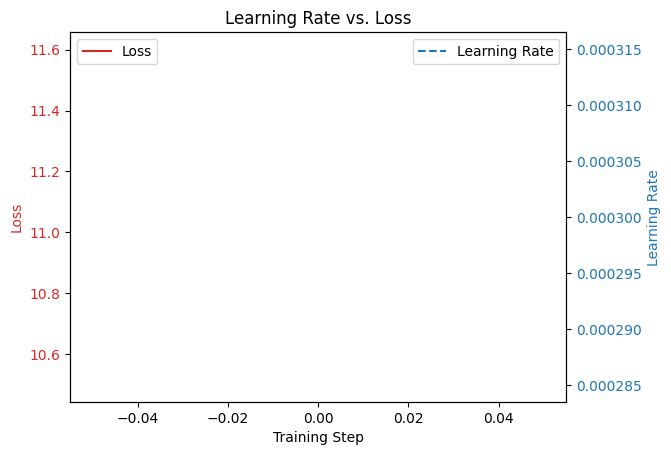

In [19]:
from matplotlib import pyplot as plt

# Ensure lr_history and loss_history are lists of equal length
assert len(lr_history) == len(loss_history), "Length of lr_history and loss_history must be the same"

fig, ax1 = plt.subplots()

# Plot Loss on primary y-axis
ax1.set_title("Learning Rate vs. Loss")
ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss", color='tab:red')
ax1.plot(range(len(loss_history)), loss_history, color='tab:red', label='Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Plot Learning Rate on secondary y-axis
ax2 = ax1.twinx()
ax2.set_ylabel("Learning Rate", color='tab:blue')
ax2.plot(range(len(lr_history)), lr_history, color='tab:blue', linestyle='--', label='Learning Rate')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


In [20]:
transformer.eval()

total_val_loss = 0.0

with torch.no_grad():
    # Use tqdm for progress bar
    progress_bar = tqdm(val_loader, desc="Validating")

    for val_src_data, val_tgt_data in progress_bar:
        # Move data to GPU
        val_src_data, val_tgt_data = val_src_data.to(device), val_tgt_data.to(device)

        # Forward pass
        val_output = transformer(val_src_data, val_tgt_data[:, :-1])

        # Calculate loss
        val_loss = F.cross_entropy(
            val_output.contiguous().view(-1, tgt_vocab_size),
            val_tgt_data[:, 1:].contiguous().view(-1),
            ignore_index=tokenizer.pad_token_id
        )

        total_val_loss += val_loss.item()

        # Update progress bar with current batch loss
        progress_bar.set_postfix({"Batch Loss": val_loss.item()})

# Calculate average validation loss
avg_val_loss = total_val_loss / len(val_loader)
print(f"Average Validation Loss: {avg_val_loss:.4f}")

Validating: 100%|██████████| 1/1 [00:00<00:00, 63.99it/s, Batch Loss=10.7]

Average Validation Loss: 10.6938


In [21]:
def translate_sentence(sentence, tokenizer, model, max_length=MAX_SEQ):
    """
    Translates a single Polish sentence into Ukrainian using greedy decoding.
    """
    model.eval()  # Set the model to evaluation mode

    # Tokenize and convert to tensor
    tokens = tokenizer.encode(sentence)
    tokens = torch.tensor(tokens).unsqueeze(0).to(device)  # Shape: (1, seq_len)
    print(tokens)

    # Start with the input sentence and an empty target sequence
    src_data = tokens
    tgt_data = torch.tensor([tokenizer.bos_token_id]).unsqueeze(0).to(device)

    with torch.no_grad():
        for _ in range(max_length):
            # Generate output (prediction for next token)
            output = model(src_data, tgt_data)

            # Get the last token's logits and find the token with the highest probability
            next_token_id = output[:, -1, :].argmax(dim=-1).item()

            # Append the predicted token to the target sequence
            tgt_data = torch.cat([tgt_data, torch.tensor([[next_token_id]]).to(device)], dim=1)

            # Stop if the model outputs the [SEP] token
            if next_token_id == tokenizer.eos_token_id:
                break

    # Decode the token ids back to the sentence
    translated_tokens = tgt_data.squeeze().tolist()
    translated_sentence = tokenizer.decode(translated_tokens, skip_special_tokens=True)

    return translated_sentence


sentence = tokenizer.decode(train_loader.dataset[0][0].tolist(), skip_special_tokens=True)
# sentence = "It also holds a share of the world's exports of beans"
print(sentence)
# sentence = "Prehistoric humans studied the relationship between the seasons and the length of days to plan their hunting and gathering activities."
translation = translate_sentence(sentence, tokenizer, transformer)
print(translation)

Site map
tensor([[    0, 40122,  5456,     2]], device='cuda:0')



In [27]:
PATH = r"my_model_translation.pt"
# torch.save(transformer.state_dict(), PATH)

In [36]:
next_model= Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
next_model.load_state_dict(torch.load(PATH, weights_only=True))
next_model = next_model.to(device)
# print(next_model)

# sentence = tokenizer.decode(train_loader.dataset[0][0].tolist(), skip_special_tokens=True)
sentence = "They are very polite."
print(sentence)
# sentence = "Prehistoric humans studied the relationship between the seasons and the length of days to plan their hunting and gathering activities."
translation = translate_sentence(sentence, tokenizer, next_model)
print(translation)

They are very polite.
tensor([[    0,  1213,    32,   182, 24908,     4,     2]], device='cuda:0')
Ils sont très soucieux de leur séjour.
